In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from timeit import default_timer
from collections import defaultdict
from tqdm import trange

class Trainer():
    def __init__(self, model, optimizer, loss_f, device, save_dir="results", is_progress_bar=True):
            self.device = device
            self.model = model.to(device)
            self.loss_f = loss_f
            self.optimizer = optimizer
            self.save_dir = save_dir
            self.is_progress_bar = is_progress_bar
            
    def __call__(self, data_loader, epochs=10, checkpoint_every=10):
        start = default_timer()
        self.model.train()
        for epoch in range(epochs):
            storer = defaultdict(list)
            mean_epoch_loss = self._train_epoch(data_loader, storer, epoch)
            mean_epoch_loss = self._test_epoch(data_loader, storer, epoch)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = self.model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           './results/samples/' + str(epoch) + '.png')
            
    def _train_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _train_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                           storer, latent_sample=latent_sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
        return loss.item()
    
    def _test_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _test_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                               storer, latent_sample=latent_sample)
            
        return loss.item()

In [4]:
LOSSES = ["betaH", "betaB"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

mnist_dataset = datasets.MNIST('/home/data/bvaa', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('/home/data/bvaa', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
from vae import VAE
from encoder import Encoder
from decoder import Decoder
from losses import get_loss_fn
from torch import optim

latent_dim = 12
img_size = [1,32,32]

lr = 5e-4

betaB_args = {"rec_dist": "bernoulli",
              "reg_anneal": 10000, 
              "betaH_B": 4,
              "betaB_initC": 0,
              "betaB_finC": 25,
              "betaB_G": 100
             }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f = get_loss_fn("betaB", n_data=len(train_loader.dataset), device=device, **betaB_args)

encoder = Encoder(img_size, latent_dim)
decoder = Decoder(img_size, latent_dim)

generator_model = VAE(img_size, latent_dim, encoder, decoder).to(device)
optimizer = optim.Adam(generator_model.parameters(), lr=lr)

In [ ]:
# trainer = Trainer(generator_model, optimizer, loss_f, device, logger=logger,\
#                   save_dir=exp_dir, is_progress_bar=False)
# epochs = 100
# checkpoint_every = 10
# trainer(train_loader, epochs=epochs, checkpoint_every=checkpoint_every)
# torch.save(trainer.model.state_dict(), 'test.pt')

In [8]:
generator_model.load_state_dict(torch.load('models/test.pt'))
# generator_model.eval()

<All keys matched successfully>

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

classifier = Classifier()
classifier.load_state_dict(torch.load('models/mnist_cnn_non_log.pt'))

<All keys matched successfully>

In [11]:
class AddNoise():
    def __init__(self, shape, device, noise=None, percent_noise=0.1):
        self.device = device
        self.percent_noise = percent_noise
        if noise is None:
            self.noise = torch.randn(shape)
        else:
            self.noise = noise

    def noisy(self, data):
        x = self.noise.to(self.device) * self.percent_noise + data * (1 - self.percent_noise)
        return x

In [12]:
sample_noise = torch.randn(torch.Size([1, 12]))
backup_sample_noise = sample_noise
print("Sample Noise for Testing: \n", sample_noise)

Sample Noise for Testing: 
 tensor([[ 1.4854, -1.3773,  0.3439, -0.6132,  1.4986, -1.8155,  0.6553, -2.3314,
         -0.1148,  0.4514,  1.7648, -0.0290]])


In [13]:
decoder = generator_model.decoder

In [71]:
class Attack(nn.Module):
    def __init__(self, target, device=device, confidence=0.6, latent_dim=10, classifier=classifier, decoder=decoder, alpha=1e-4, noise=sample_noise):
        super(Attack, self).__init__()
        self.decoder = decoder.to(device)
#         self.decoder.eval()
        self.classifier = classifier.to(device)
#         self.classifier.eval()
        self.alpha = alpha
        self.target = target
        self.confidence = confidence
        
    def forward(self, x, noise):
        
        # original predictions
        org = self.decoder(x)
        org_pred = self.classifier(F.upsample(org, (28,28), mode='bilinear', align_corners=True))
#         org_pred_label = torch.argmax(org_pred, dim=1)
        
        # noise addition
        noised = torch.add((1 - self.alpha) * x, self.alpha * noise)
        self.noise = noise
        
        # reconstructed image predictions
        recon = self.decoder(noised)
        recon_pred = self.classifier(F.upsample(recon, (28,28), mode='bilinear', align_corners=True))
#         recon_pred_label = torch.argmax(pred, dim=1)
        
        # target soft labels
#         alt_truth = torch.zeros(recon_pred.shape, dtype=torch.float64)
#         alt_truth[:, self.target] = torch.FloatTensor([self.confidence]*recon_pred.shape[0])
#         alt_truth[range(alt_truth.shape[0]), recon_pred_label] += torch.FloatTensor([1-self.confidence]*alt_truth.shape[0])
        return org_pred, recon_pred
    
attack = Attack(target=2)
attack.eval()

Attack(
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (classifier): Classifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [72]:
# Constrained Translator
class Translator(nn.Module):
    def __init__(self, hidden_layers=[10, 512, 1024, 2048, 10], latent_dim=latent_dim):
        super(Translator, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, pred):
        for layer in self.layers:
            pred = layer(pred)
        
        return pred

translator = Translator().to(device)
translator.train()

Translator(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=2048, bias=True)
    (3): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [15]:
a = torch.randn((4,5))
a[range(a.shape[0]), [0,1,2,1]] = torch.Tensor([0]*a.shape[0])
a

tensor([[ 0.0000,  0.5960, -0.5329, -1.3138,  0.2355],
        [ 0.8949,  0.0000, -1.3279, -0.1522,  0.1627],
        [ 1.0288,  0.0804,  0.0000, -1.9471, -1.9165],
        [ 0.1477,  0.0000,  0.2170,  1.6146,  0.4004]])

In [75]:
def create_logits(target_label, org_pred_label, target_pred, confidence=0.6):
    logits = torch.zeros(target_pred.shape, dtype=torch.float64)
    target_pred_labels = torch.argmax(target_pred, dim=1)
#     print(logits.shape)
    logits[:, target_pred_labels] = torch.DoubleTensor([1-confidence]*target_pred.shape[0])
    logits[:, [target_label]*target_pred.shape[0]] += torch.DoubleTensor([confidence]*target_pred.shape[0])
    return logits.to(device)

class T_Loss(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(T_Loss, self).__init__()
        self.latent_dim = latent_dim
    
    def forward(self, org_pred, target_pred, target_label, loss_fn="ALoss"):
        self.batch_size = org_pred.shape[0]
        if loss_fn is "ALoss":
            loss = self.aloss(org_pred, recon_pred, target_label)
        
        return loss
    
    def aloss(self, org_pred, target_pred, target_label):
        reconstruction_loss = F.mse_loss(target_pred, org_pred, reduction="sum") / self.batch_size
        org_pred_label = torch.argmax(org_pred, dim=1)
        target_pred_label = torch.argmax(target_pred, dim=1)
        soft_logits = create_logits(target_label, org_pred_label, target_pred)
        gen_loss = F.binary_cross_entropy(target_pred, soft_logits.float())
        return reconstruction_loss + gen_loss

In [76]:
tloss = T_Loss().to(device)

In [77]:

attack_log_interval = 1
alt_target = 2
attack.eval()
criterion = nn.BCELoss()
optimizer_attack = optim.Adam(translator.parameters(), lr=1e-3)
for epoch in tqdm(range(100)):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.FloatTensor(data).to(device)
        
#         sample_noise.requires_grad_(True)
        
        _, l_dist, l_sample = generator_model(data)
        
        org_pred, recon_pred = attack(l_sample, sample_noise.to(device))
        target_pred = translator(recon_pred)
        
        loss = tloss(org_pred, target_pred, alt_target)
        loss.backward()
        optimizer_attack.step()
#         noise_grad = torch.autograd.grad(loss, attack.noise, create_graph=True)
#         noise_grad = sample_noise.grad.data
        
#         print(noise_grad)
    
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(
            epoch, 100. * batch_idx / len(train_loader), loss.item()))
        

Train Epoch: 0	Loss: 99.893390
Train Epoch: 1	Loss: 99.893390
Train Epoch: 2	Loss: 99.893390
Train Epoch: 3	Loss: 99.893390
Train Epoch: 4	Loss: 99.893390
Train Epoch: 5	Loss: 99.893390
Train Epoch: 6	Loss: 99.893390
Train Epoch: 7	Loss: 99.893390
Train Epoch: 8	Loss: 99.893390
Train Epoch: 9	Loss: 99.893390
Train Epoch: 10	Loss: 99.893390
Train Epoch: 11	Loss: 99.893390
Train Epoch: 12	Loss: 99.893390
Train Epoch: 13	Loss: 99.893390
Train Epoch: 14	Loss: 99.893390
Train Epoch: 15	Loss: 99.893390
Train Epoch: 16	Loss: 99.893390
Train Epoch: 17	Loss: 99.893390
Train Epoch: 18	Loss: 99.893390
Train Epoch: 19	Loss: 99.893390
Train Epoch: 20	Loss: 99.893390
Train Epoch: 21	Loss: 99.893390
Train Epoch: 22	Loss: 99.893390
Train Epoch: 23	Loss: 99.893390
Train Epoch: 24	Loss: 99.893390
Train Epoch: 25	Loss: 99.893390
Train Epoch: 26	Loss: 99.893390
Train Epoch: 27	Loss: 99.893390
Train Epoch: 28	Loss: 99.893390
Train Epoch: 29	Loss: 99.893390
Train Epoch: 30	Loss: 99.893390
Train Epoch: 31	Lo

In [216]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([1, 3, 0])

In [226]:
# target
# target.reshape(64,1) == torch.arange(10).reshape(1, 10)).float()

In [13]:
# noise_check = {}
# for perc in tqdm(list(np.arange(0, 1, 0.00001))):
#     recon_img = generator_model.decoder(perc*sample_noise.cuda())
#     pred = classifier(F.upsample(recon_img, (28,28), mode='bilinear', align_corners=True).cpu())
#     pred_label = torch.argmax(pred).item()
#     if pred_label not in noise_check.keys():
#         noise_check[pred_label] = [perc]
#     else:
#         noise_check[pred_label].append(perc)
# #     plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
# #     print(torch.argmax(classifier(F.upsample(recon_img, (28,28), mode='bilinear', align_corners=True).cpu())))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [14]:
noise_check.keys()

dict_keys([8, 7, 3, 9, 6, 5, 0, 1])

In [15]:
for key in noise_check.keys():
    print("{}: {}".format(key, len(noise_check[key])))

8: 33186
7: 1
3: 11
9: 3
6: 49
5: 66745
0: 4
1: 1


In [37]:
print("{}-{}".format(noise_check[8][0], noise_check[8][-1]))
print("{}-{}".format(noise_check[5][0], noise_check[5][-1]))

0.0-0.37484
0.25843000000000005-0.99999


tensor(8)


/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


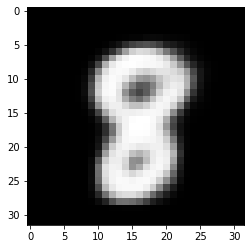

In [30]:
recon_img = generator_model.decoder(0.005*sample_noise.cuda())
pred = classifier(F.upsample(recon_img, (28,28), mode='bilinear', align_corners=True).cpu())
print(torch.argmax(pred))
plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [20]:
def evaluate(i, percentage, sample_noise=sample_noise):
    recon_img,l_dist,l_sample = generator_model(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
    noise = AddNoise(l_sample.shape, device, sample_noise, percent_noise=percentage)
    l_sample_noised = noise.noisy(l_sample)
    recon_noised = generator_model.decoder(l_sample_noised)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(example_data[i].unsqueeze(0), (28,28), mode='bilinear').to(device))).item()))
    plt.subplot(1,3,2)
    plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(recon_img, (28,28), mode='bilinear').to(device))).item()))
    plt.subplot(1,3,3)
    plt.imshow(recon_noised[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(recon_noised, (28,28), mode='bilinear').to(device))).item()))

### Evaluation

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


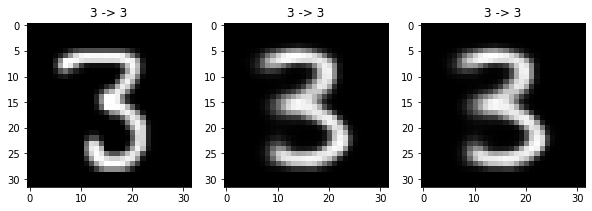

In [21]:
evaluate(9, 0)

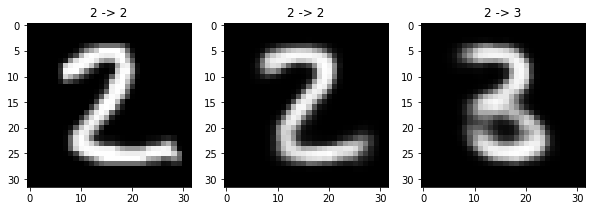

In [22]:
evaluate(8, 0.152)

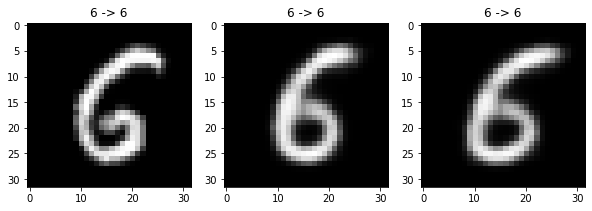

In [21]:
evaluate(18, 0.190)

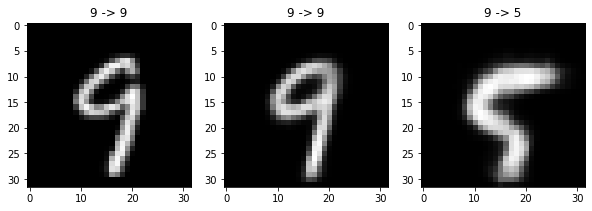

In [22]:
evaluate(11, 0.31)

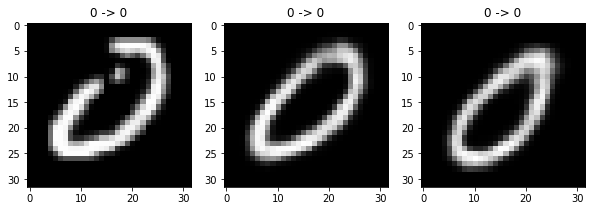

In [23]:
evaluate(13, 0.454)